# <b>Step 0</b>: Creating a Noise Model for Micro$\mathbb{S}$plit

# Introduction - what does this notebook do?

<div class="alert alert-block alert-info">
The objective of this notebook is to train a suitable Noise Model for the microscope that produced the data you want to train a Micro$\mathbb{S}$plit model for.

Note that <b>the execution of this notebook is optional if your goal is to simply reproduce results for our paper</b>. If, on the other hand, you aim at modifying this notebook to split apart superimposed channels in your own data, a suitable noise model for your data will have to be created.
</div>

## What is a Noise Model?

Noise models, as we use them, are a collection of mappings from true pixel intensities to observed (noisy) intensity measurements, and vice-versa (see also <font color='red'><i>link to noise model page on CAREamics documentation</i></font>).

Noise models originate from other works on unsupervised denoising <font color='red'><i>[link,link,link]</i></font>, and are serving a similar purpose also for us. Given a noisy pixel intensity, a noise models returns a distribution of potential true signal values and their empirically measured probabilities. We use Noise Models as described in [Interpretable Unsupervised Diversity Denoising and Artefact Removal](https://arxiv.org/abs/2104.01374).

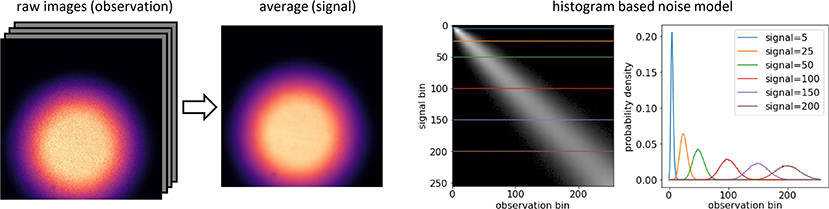

## How to train your own Noise Model - an overview

### If you have access to the microscope that produced the data you want to use during training
As described in detail in the papers we linked above, you must obtain microscopy images that are noisy and cover the relevant range of pixel intensities that are also covered by the data you want to use.

Note that it is NOT important that this data shows any specific structures. You can literally image anything you want. In the original <font color='red'><i>PN2V paper</i></font> we have, for example, just imaged the backfocal aperture over and over, making sure that nothing moves and each of the $n$ images we captured is just yet another noisy version of the same image content (see also the image above).

The reason for this is that we can then average those $n$ noisy copies pixel by pixel into a much noise reduced (lets refer to this image as the noise-free ground truth) image.

In order to create the above memtioned mapping between "true" pixel intensities and the observed distribution of noisy measurements, one could simply ceck for each pixel in the averaged ground truth image, what noisy values we imaged in the $n$ noisy copies.

Since this will lead to situations where rare intensities are not observed frequently enough to make a good mapping, we are using a Gaussian Mixture Model <font color='red'><i>[link]</i></font>, just as originally proposed in <font color='red'><i>?PPN2V?</i></font>.

Anyways, what precisely happens under the hood is not required for you to understand in detail. Just execute the notebook below and later use the created noise model to give you MicroSplit network the chance to get rid of the noise your microscope is producing!

### You do not have access to the microscope that produced your training data
What we just described above requires you to go to the microscope that produced the data you want to use in <font color='red'><i>MicroSplit</i></font> and acquire appropriate images. If you do not have access to the microscope (or would like to avoid going through the exercise of creating the appropriate data), you can "bootstrap" yourself to a noise model that often also works sufficiently well.



# Let's do it, let's train a Noise Model!

In [1]:
# importing all the things we need further down

import numpy as np
import pooch
import matplotlib.pyplot as plt

from careamics import CAREamist
from careamics.models.lvae.noise_models import GaussianMixtureNoiseModel, create_histogram
from careamics.lvae_training.dataset import DataSplitType
from careamics.config import GaussianMixtureNMConfig
from careamics.config import create_n2v_configuration

from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data
from microsplit_reproducibility.utils.utils import plot_probability_distribution

# Data Preparation

If you want to use your own data, you will have to change this section in an appropriate way.

As is, we will first choose which subset of the *HT_LIF24* dataset to use, since our paper proposes multiple splitting tasks with different data subsets. This logic will very likely not apply to your won use-case, but makes total sense if you want to reproduce any of our results with this dataset.

In [17]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

class Channels:
    Nucleus = 0
    MicroTubules = 1
    NuclearMembrane = 2
    Centromere = 3

class ExposureDuration:
    VeryLow = "2ms"
    Low = "3ms"
    Medium = "5ms"
    High = "20ms"
    VeryHigh = "500ms"

allowed_exposure_durations = [ExposureDuration.VeryLow, ExposureDuration.Low, ExposureDuration.Medium, ExposureDuration.High, ExposureDuration.VeryHigh]

### Select the channels and exposure duration
<div class="alert alert-block alert-info">
<b> Task: </b>Set two entries from the following list for the channels.
0 - Nucleus, 1 - Microtubules, 2 - Centromere, 3 - Nuclear Membrane
An example would be [0, 1] for Nucleus and Microtubules.
</div>

In [3]:
TARGET_CHANNEL_IDX_LIST = [Channels.MicroTubules, Channels.Nucleus]

<div class="alert alert-block alert-info">
<b> Task: </b>Pick one entry from the following list for the exposure duration.
VeryLow, Low,Medium,High, VeryHigh
</div>

In [4]:
EXPOSURE_DURATION = ExposureDuration.Medium


In [5]:
TARGET_CHANNEL_IDX_LIST = sorted(TARGET_CHANNEL_IDX_LIST)
assert EXPOSURE_DURATION in allowed_exposure_durations, f"Exposure duration {EXPOSURE_DURATION} not in {allowed_exposure_durations}"
assert len(TARGET_CHANNEL_IDX_LIST) == 2, f"Only 2 target channels are allowed, got {len(TARGET_CHANNEL_IDX_LIST)}"

In [6]:
from notebook_utils import get_all_channel_list
CHANNEL_IDX_LIST = get_all_channel_list(TARGET_CHANNEL_IDX_LIST)

### Download the data

In [7]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data/",
    registry={f"ht_lif24_{EXPOSURE_DURATION}.zip": None},
)
for key in DATA.registry:
    DATA.fetch(key)


In [8]:
train_data_config, val_data_config, test_data_config = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST,
)

In [9]:
input_data = get_train_val_data(data_config=train_data_config,
                                datadir=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
                                datasplit_type=DataSplitType.Train,
                                val_fraction=0.1,
                                test_fraction=0.1,)

Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: Fals

In [10]:
# We use a subset of the data for training the noise model
train_data = input_data[0:-1:10, :, :, :-1].squeeze()

### Create N2V configuration

In [11]:
config = create_n2v_configuration(
    experiment_name="ht_lif24",
    data_type="array",
    axes="SYXC",
    n_channels=2,
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=1,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 2,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 2},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYXC',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
   

### Train N2V 
For unsupervised denoising, we use [Noise2Void - Learning Denoising from Single Noisy Images](https://arxiv.org/abs/1811.10980) (N2V) which is a deep-learning-based method for denoising images. 

In [12]:
careamist = CAREamist(source=config)
# train
careamist.train(train_source=train_data,val_minimum_split=5)

No working directory provided. Using current working directory: /home/ashesh.ashesh/code/microSplit-reproducibility/examples/2D/HT_LIF24.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [100.39856  102.160484], std: [3.8893647 7.2918286]
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ashesh.ashesh/code/microSplit-reproducibility/examples/2D/HT_LIF24/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.0 M  | train
---------------------------------------
1.0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 86/86 [00:19<00:00,  4.48it/s, train_loss_step=0.53, val_loss=0.506, train_loss_epoch=0.547]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 86/86 [00:19<00:00,  4.40it/s, train_loss_step=0.53, val_loss=0.506, train_loss_epoch=0.547]


In [13]:
prediction = careamist.predict(train_data, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize N2V predictions

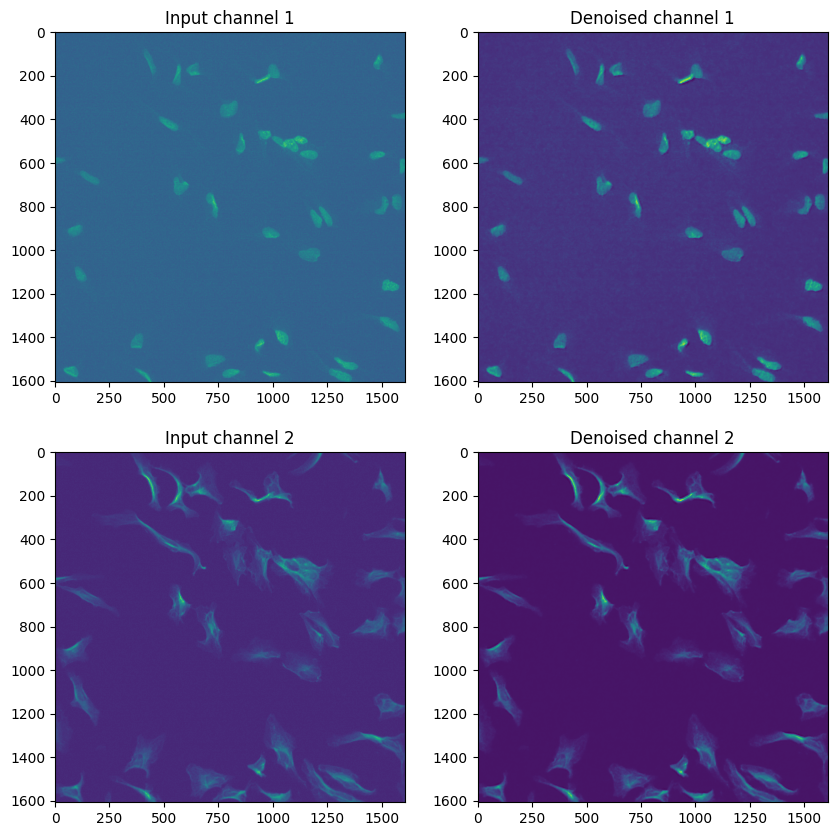

In [14]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(train_data[0, ..., 0])
ax[0][0].set_title("Input channel 1")
ax[0][1].imshow(prediction[0].squeeze()[0])
ax[0][1].set_title("Denoised channel 1")
ax[1][0].imshow(train_data[0, ..., 1])
ax[1][0].set_title("Input channel 2")
ax[1][1].imshow(prediction[0].squeeze()[1])
ax[1][1].set_title("Denoised channel 2")
plt.show()

### Train the noise model and visualize the results

Here we train a noise model using the denoised images aquired from the N2V model.

We train a separate noise model for each channel.


Training noise model for channel 0
[GaussianMixtureNoiseModel] min_sigma: 200.0
0 3.595200538635254

The trained parameters (nm_ht_lif24_ch1_20ms) is saved at location: noise_models
Training noise model for channel 1
[GaussianMixtureNoiseModel] min_sigma: 200.0
0 3.6023449897766113

The trained parameters (nm_ht_lif24_ch2_20ms) is saved at location: noise_models


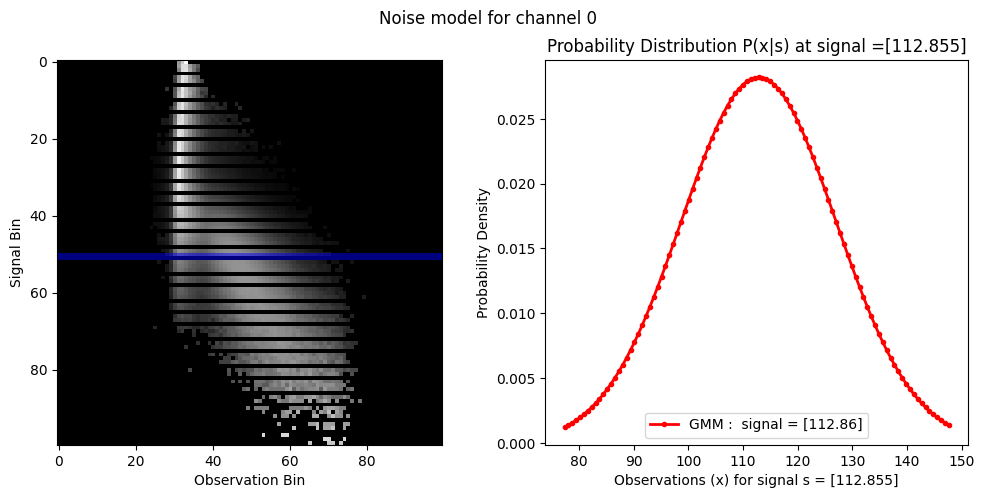

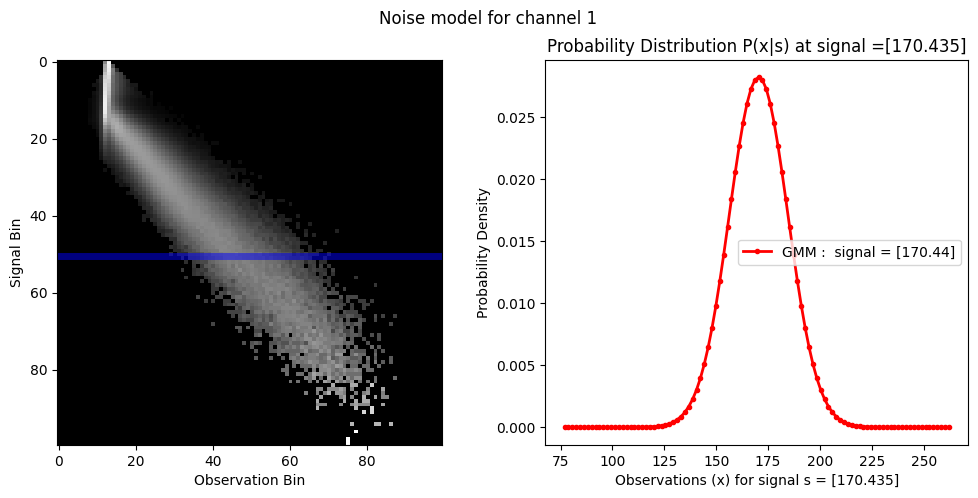

In [15]:
for channel_idx in range(train_data.shape[-1]):
    channel_data = train_data[..., channel_idx]
    channel_prediction = np.concatenate(prediction)[:, channel_idx]
    print(f"Training noise model for channel {channel_idx}")
    noise_model_config = GaussianMixtureNMConfig(model_type="GaussianMixtureNoiseModel",
                                             min_signal=channel_data.min(),
                                                max_signal=channel_data.max(),
)
    noise_model = GaussianMixtureNoiseModel(noise_model_config)
    noise_model.fit(signal=channel_data, observation=channel_prediction, n_epochs=100) # TODO change n_epochs
    noise_model.save(path="noise_models", name=f"nm_ht_lif24_ch{channel_idx + 1}_20ms")
    histogram = create_histogram(bins=100, min_val=channel_data.min(), max_val=channel_data.max(), signal=channel_data, observation=channel_prediction)
    plot_probability_distribution(noise_model, signalBinIndex=50, histogram=histogram[0], channel=channel_idx)

    